In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
a_df = pd.read_csv("idosorok/A.csv")
b_df = pd.read_csv("idosorok/B.csv")
c_df = pd.read_csv("idosorok/C.csv")
a_df["is_anomaly"] = 0
b_df["is_anomaly"] = 0
c_df["is_anomaly"] = 0
a_df.to_csv("idosorok/A_annotated.csv", index=None)
b_df.to_csv("idosorok/B_annotated.csv", index=None)
c_df.to_csv("idosorok/C_annotated.csv", index=None)

In [3]:
a_df["timestamp"] = pd.to_datetime(a_df["timestamp"])
b_df["timestamp"] = pd.to_datetime(b_df["timestamp"])
c_df["timestamp"] = pd.to_datetime(c_df["timestamp"])

In [4]:
a_df = a_df[11520:].reset_index(drop=True)
c_df = c_df[1440:].reset_index(drop=True)
a_set = a_df.copy()

In [8]:
fig = make_subplots(rows=1, cols=1,
                    specs=[[{"rowspan": 1, "secondary_y": True}]],
                    vertical_spacing=0.02, shared_xaxes=True)
fig.append_trace(go.Scattergl(x=c_df["timestamp"],
                              y=c_df["value"], name="original data",
                              line=dict(color='blue', width=2)), row=1, col=1)
fig.write_html(f"idosorok/c_dataset.html", auto_open=False)

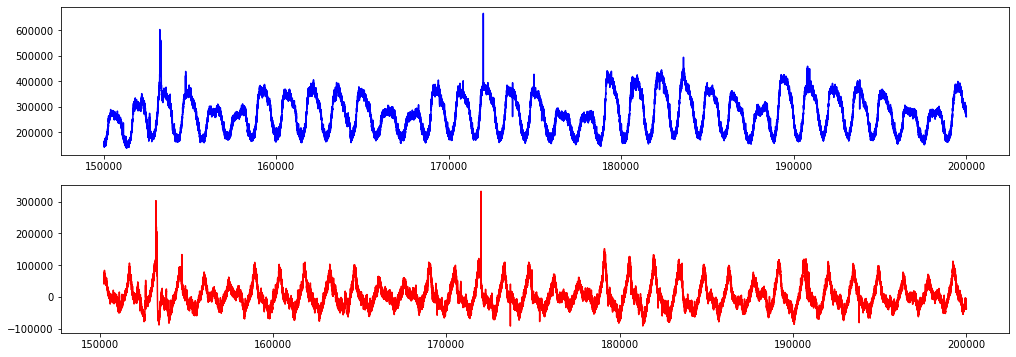

In [87]:
fig, axs = plt.subplots(2, figsize=(17,6))
s = 150000
l = 50000
axs[0].plot(b_df["value"][s:  s + l], "blue")
axs[1].plot(b_df["value"][s: s + l] - b_df["value"][s: s + l].rolling(240).mean(), "red")

In [125]:
def plot_z(df):
    fig, axs = plt.subplots(2, figsize=(17,6))
    cut = df.shape[0]
    data = df["value"][:cut]
    r_mean = data.rolling(60).mean()
    r_std = data.rolling(60).std()
    z = (data - r_mean) / r_std
    axs[0].plot(data, "blue")
    axs[0].plot(r_mean, "red")
#     axs[0].plot(r_mean - 2 * r_std, "yellow")
#     axs[0].plot(r_mean + 2 * r_std, "green")
    axs[1].plot(z, "green")

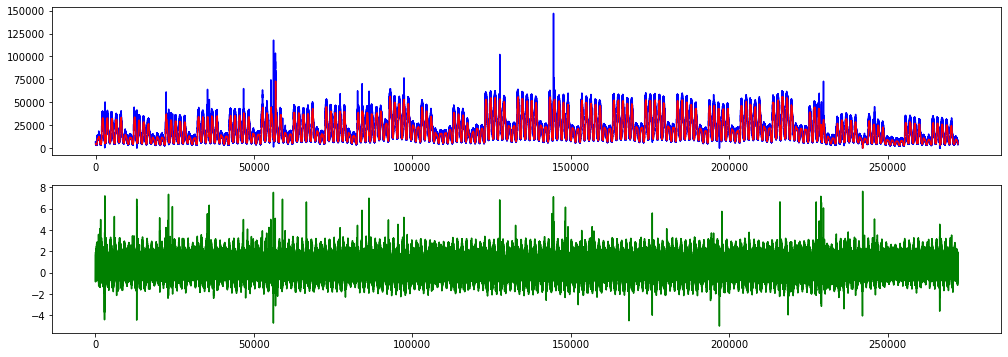

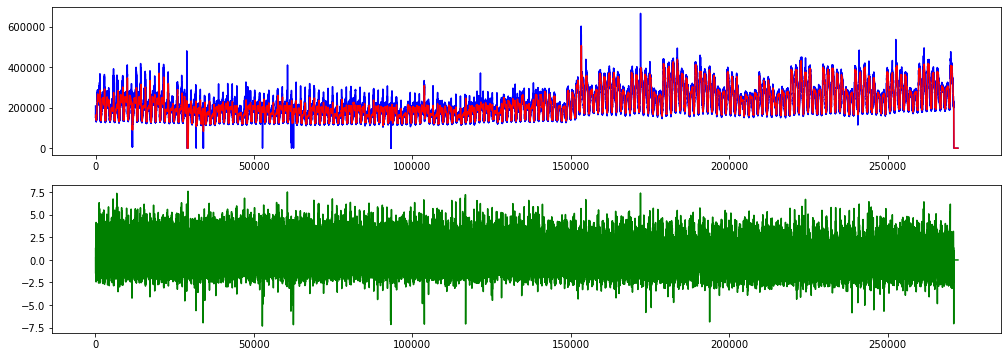

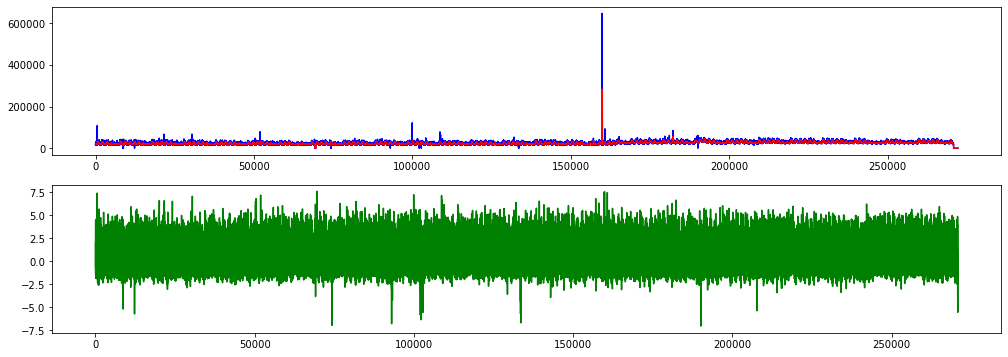

In [126]:
plot_z(a_df)
plot_z(b_df)
plot_z(c_df)

In [91]:
def detect_low(df):
    data = df["value"]
    actual_data = data.copy()
    
    anoms = 0 * data
    vol = data.rolling(15).mean() - data.rolling(240).mean()
    r_min = actual_data.rolling(60).mean().rolling(60*24*7).min()
    
    for i in range(60*24*7, data.shape[0]):
        if i % 10000 == 0:
            print(i)
        below = r_min.values[i] - data.values[i]
        if below > 50000:
            anoms[i] = 1
            actual_data[i] = r_min.values[i]
            r_min = actual_data.rolling(60).mean().rolling(60*24*7).min()
    return anoms, r_min

In [180]:
def plot_range(df):
    fig, axs = plt.subplots(2, figsize=(17,6), sharex=True)
    cut = 32000
    data = df["value"][:cut]
    r_min = data.rolling(60).mean().rolling(60*24*7).min()
    vol = data.rolling(15).mean() - data.rolling(240).mean()
    axs[0].plot(data)
    axs[0].plot(r_min, "red")
    axs[1].plot(vol, "green")

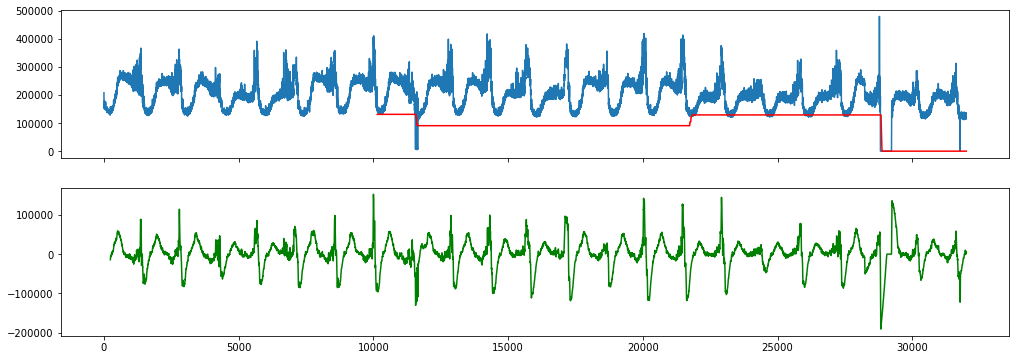

In [181]:
plot_range(b_df)

20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000


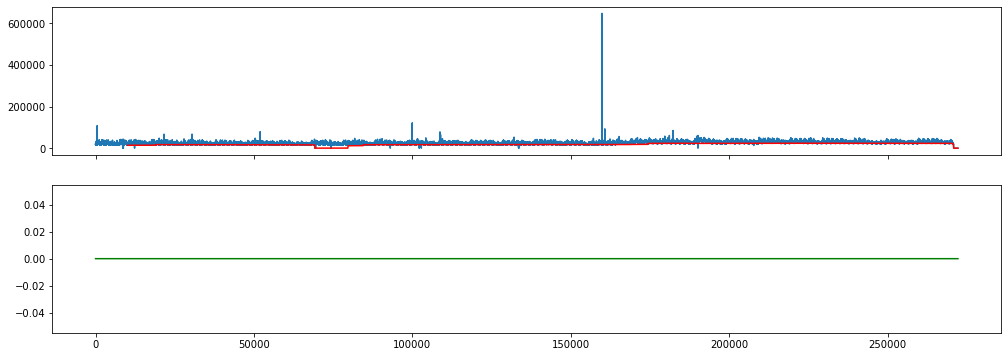

In [97]:
fig, axs = plt.subplots(2, figsize=(17,6), sharex=True)
data = c_df["value"]
anoms, mins = detect_low(c_df)
axs[0].plot(data)
axs[0].plot(mins, "red")
axs[1].plot(anoms, "green")

In [96]:
df = b_df
fig = make_subplots(rows=2, cols=1,
                    specs=[[{"rowspan": 1, "secondary_y": True}],
                           [{"rowspan": 1, "secondary_y": True}]],
                    vertical_spacing=0.02, shared_xaxes=True)
fig.append_trace(go.Scattergl(x=df["timestamp"],
                              y=df["value"], name="original data",
                              line=dict(color='blue', width=2)), row=1, col=1)
fig.append_trace(go.Scattergl(x=df["timestamp"],
                              y=df["value"].rolling(240).mean(),
                              name=f"rolling mean lag = 240",
                              line=dict(color='black', width=2)), row=1, col=1)
fig.append_trace(go.Scattergl(x=df["timestamp"],
                              y=mins,
                              name=f"rolling min without anomalies",
                              line=dict(color='red', width=2)), row=1, col=1)
fig.append_trace(go.Scattergl(x=df["timestamp"],
                              y=(df["value"] - df["value"].rolling(240).mean()) > 200000,
                              name="is high",
                              line=dict(color='green', width=2)), row=2, col=1)
fig.append_trace(go.Scattergl(x=df["timestamp"],
                              y=anoms * 1,
                              name="is low",
                              line=dict(color='red', width=2)), row=2, col=1)
fig.write_html(f"b_low_or_high.html", auto_open=False)

In [73]:
def plot_z_score(df, out_name, lag, lag_std, th_upper, th_lower):
    r_mean = df["value"].rolling(lag).mean()
    r_std = df["value"].rolling(lag_std).std()
    z = (df["value"] - r_mean) / r_std
    fig = make_subplots(rows=2, cols=1,
                        specs=[[{"rowspan": 1, "secondary_y": True}],
                               [{"rowspan": 1, "secondary_y": True}]],
                        vertical_spacing=0.02, shared_xaxes=True)
    fig.append_trace(go.Scattergl(x=df["timestamp"],
                                  y=df["value"], name="original data",
                                  line=dict(color='blue', width=2)), row=1, col=1)
    fig.append_trace(go.Scattergl(x=df["timestamp"],
                                  y=r_mean,
                                  name=f"rolling mean lag = {lag}",
                                  line=dict(color='black', width=2)), row=1, col=1)
    fig.append_trace(go.Scattergl(x=df["timestamp"],
                                  y=z,
                                  name=f"Z score",
                                  line=dict(color='green', width=2)), row=2, col=1)
    fig.add_trace(go.Scattergl(x=df["timestamp"],
                                  y=1*(z<th_lower) + 1*(z>th_upper),
                                  name=f"Is anomaly",
                                  line=dict(color='red', width=2)), secondary_y=True, row=2, col=1)
    fig.write_html(f"{out_name}.html", auto_open=False)

In [74]:
plot_z_score(b_df, "rolling_z_b", 120, 240, 8, -6)

In [105]:
# a moving average to smooth the timeseries
smoothed = a_df["value"].rolling(60).mean().fillna(a_df["value"][0])
# create an array which contains an expected curve for each day, based on past data
expectations_on_days = []
alpha = 0.1
# drop the first day, as the first expected curve will correspond to the second day
# also we drop 10 days because of the bad EMA calc
a_df = a_df[1440 + 10 * 1440:].reset_index(drop=True)
for i in range(189):
    day = smoothed[i * 60 * 24: (i + 1) * 60 * 24].values
    if len(expectations_on_days) == 0:
        expectations_on_days.append(day)
    else:
        expectations_on_days.append(day)
#         expectations_on_days.append(expectations_on_days[-1] * (1 - alpha) + day * alpha)
# last expected curve has no correspondinng data, so we drop it
expectations_on_days = expectations_on_days[10: -1]
# drop days from the smoothed too, to keep it usable
smoothed = smoothed[1440 + 10 * 1440:].reset_index(drop=True)

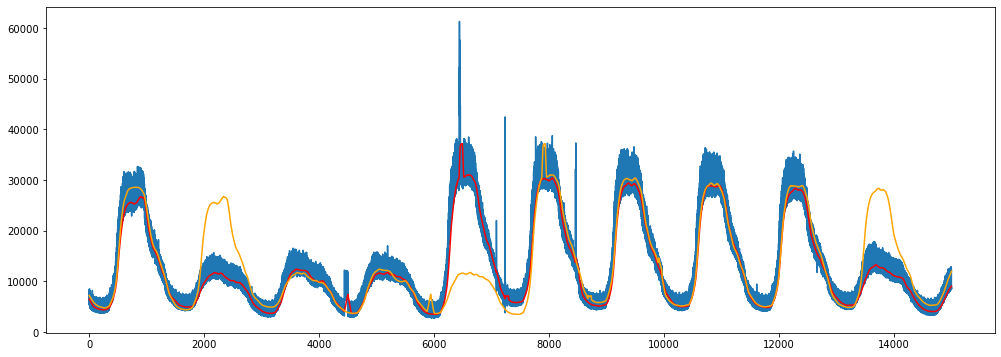

In [106]:
plt.figure(figsize=(17,6))
plt.plot(a_df["value"][:15000])
plt.plot(smoothed[:15000], "red")
plt.plot(np.hstack(expectations_on_days)[:15000], "orange")

In [36]:
expectations_on_days

[array([7045.        , 7045.        , 7045.        , ..., 7289.08333333,
        7269.91666667, 7277.56666667]),
 array([7069.91      , 7070.09666667, 7068.125     , ..., 7350.2       ,
        7330.56666667, 7335.16333333]),
 array([7146.22566667, 7143.84533333, 7139.59083333, ..., 7410.345     ,
        7389.44833333, 7391.31866667]),
 array([7218.0431    , 7213.10746667, 7206.11508333, ..., 7415.3705    ,
        7394.64183333, 7394.55346667]),
 array([7236.29212333, 7229.92005333, 7221.608575  , ..., 7525.04011667,
        7504.19265   , 7502.03978667]),
 array([7357.61457767, 7349.90138133, 7340.27605083, ..., 7597.23777167,
        7576.26171833, 7572.14914133]),
 array([7439.94645323, 7430.84457653, 7420.24844575, ..., 7454.78732783,
        7434.31887983, 7429.5242272 ]),
 array([7309.27680791, 7300.18178555, 7289.48360118, ..., 7323.70859505,
        7302.75532518, 7296.31347115]),
 array([7185.57246045, 7175.36694033, 7163.21024106, ..., 7393.77606888,
        7371.16479267, 

In [2]:
a_htm = pd.read_csv("data_results/NumentaDetectorTM/NumentaDetectorTM_A.csv")

In [4]:
a_htm["timestamp"] = pd.to_datetime(a_htm["timestamp"])
a_htm.head()

,timestamp,value,anomaly_score,raw_score,label
0,2019-12-14 00:00:00,674.0,0.030103,1.0,0
1,2019-12-14 00:01:00,521.0,0.030103,1.0,0
2,2019-12-14 00:02:00,482.0,1.000000,1.0,0
3,2019-12-14 00:03:00,504.0,0.030103,1.0,0
4,2019-12-14 00:04:00,431.0,1.000000,1.0,0


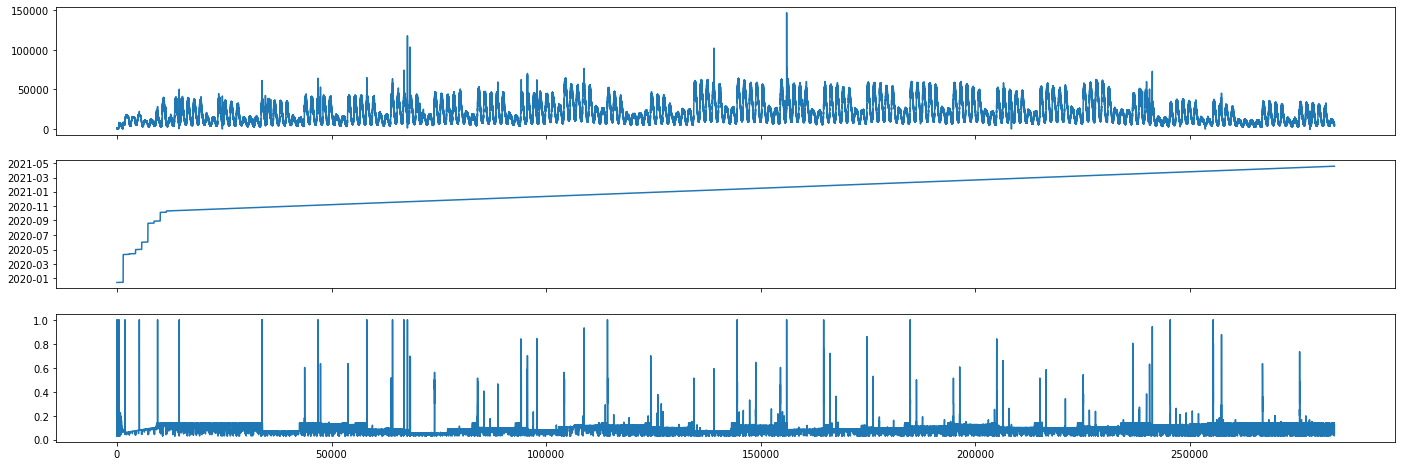

In [7]:
fig, axs = plt.subplots(3, 1, sharex = True, figsize=(24, 8))
axs[0].plot(a_htm["value"])
axs[1].plot(a_htm["timestamp"])
axs[2].plot(a_htm["anomaly_score"])

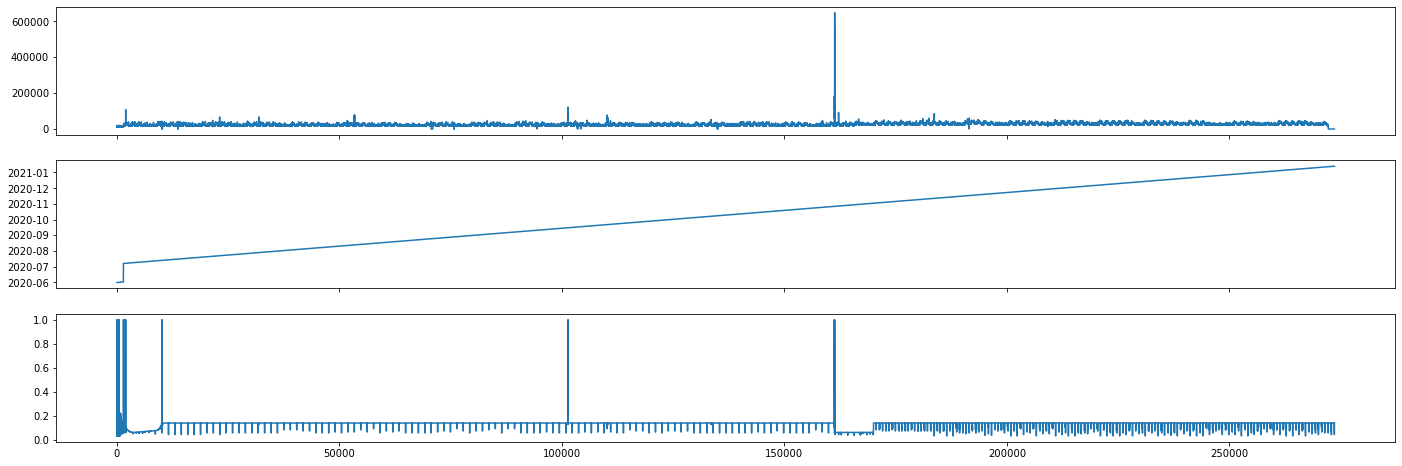

In [20]:
b = pd.read_csv("data_results/NumentaDetectorTM/NumentaDetectorTM_C.csv")
b["timestamp"] = pd.to_datetime(b["timestamp"])
fig, axs = plt.subplots(3, 1, sharex = True, figsize=(24, 8))
axs[0].plot(b["value"])
axs[1].plot(b["timestamp"])
axs[2].plot(b["anomaly_score"])

In [21]:
fig = make_subplots(rows=2, cols=1,
                    specs=[[{"rowspan": 1, "secondary_y": True}],
                           [{"rowspan": 1, "secondary_y": True}]],
                    vertical_spacing=0.02, shared_xaxes=True)
fig.append_trace(go.Scattergl(x=b["timestamp"],
                                              y=b["value"], name="B chunk",
                                              line=dict(color='green', width=2)), row=1, col=1)
fig.append_trace(go.Scattergl(x=b["timestamp"],
                                              y=b["anomaly_score"], name="Numenta HTM TM anomaly score",
                                              line=dict(color='red', width=2)), row=2, col=1)
fig.write_html("c_numenta_htm_tm.html", auto_open=False)

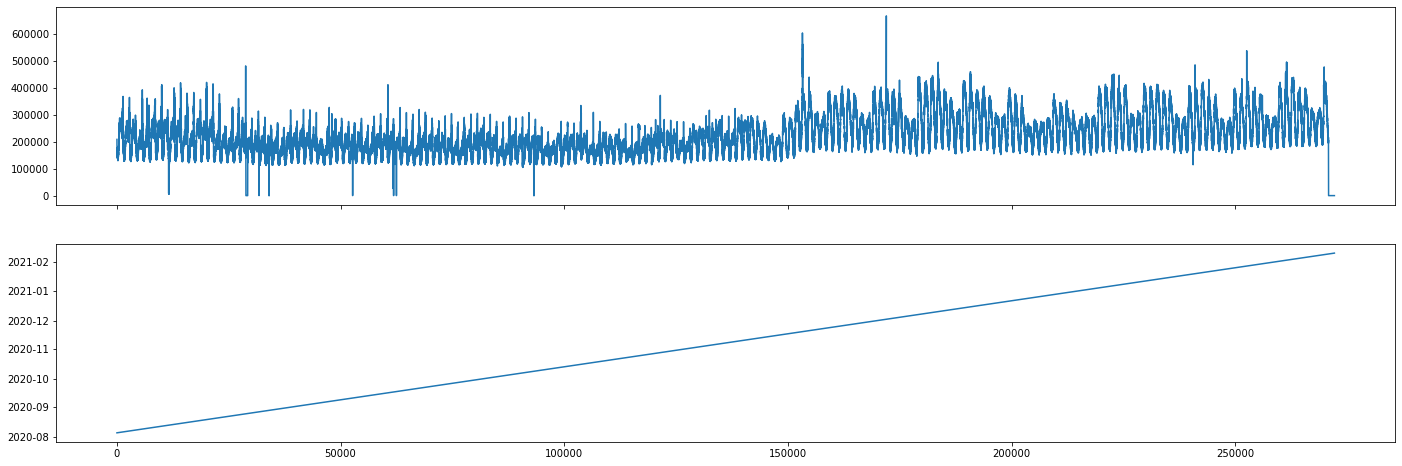

In [5]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize=(24, 8))
axs[0].plot(b_df[1])
axs[1].plot(b_df["time"])

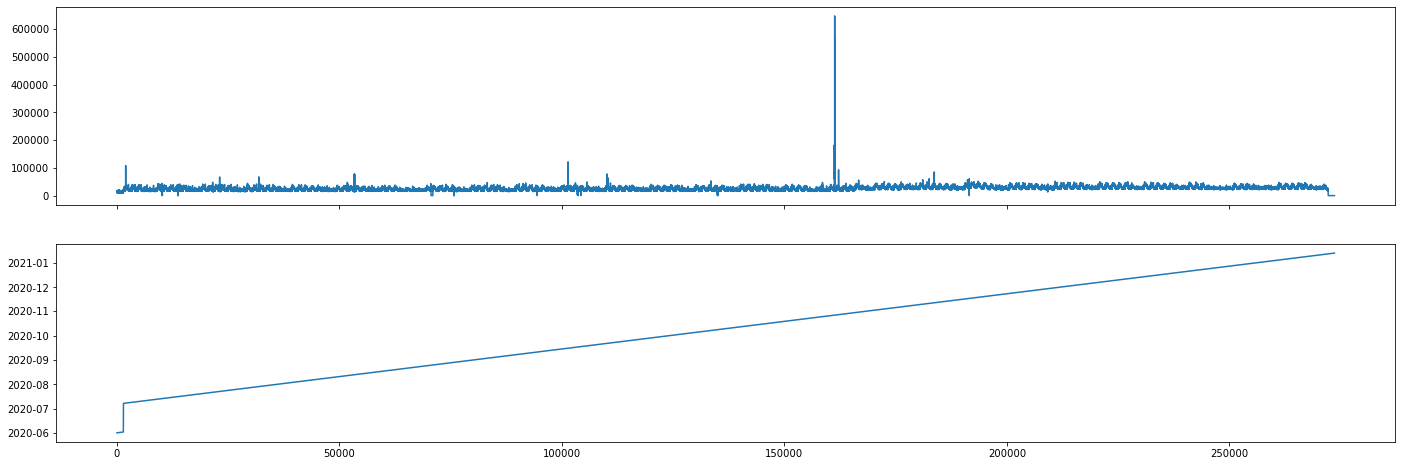

In [6]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize=(24, 8))
axs[0].plot(c_df[1])
axs[1].plot(c_df["time"])

In [5]:
#LSTM PREDICTION ERROR METHOD

In [13]:
import pandas as pd
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend


def tsToSupervised(ts, lag_size, step_out):
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(lag_size, 0, -1):
        cols.append(ts.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, step_out):
        cols.append(ts.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

def model_predict(model, history, lag_size):
    x_input = np.array(history[-lag_size:]).reshape((1, lag_size, 1))
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

def drawTimeSeries(originalData, predictedData, outputdirname, length):
    DirName = outputdirname
    isDir = os.path.isdir(DirName)
    if not isDir:
        os.makedirs(DirName)
    name = "Forecasted Signal"
    plt.figure(figsize=(15, 5))
    plt.xlabel('time')
    plt.ylabel('Response value')
    plt.title(name)
    #length = len(originalData)
    # plt.plot(np.arange(len(originalData)), originalData[:-length], color='blue', linestyle="-", label="original")
    # plt.plot(np.arange(0, len(predictedData)), predictedData[:-length], color='red', linestyle="-", label="observed")
    plt.plot(np.arange(length), originalData[:length], color='blue', linestyle="-", label="original")
    plt.plot(np.arange(0, length), predictedData[:length], color='red', linestyle="-", label="predicted")
    plt.legend()
    plt.grid(True)
    plt.savefig(DirName + "/" + name + ".png")
    plt.close()

def getXtrainYtrain(data, lag_size, step_out):
    train_x, train_y = data[:, :lag_size], data[:, lag_size:]
    return train_x, train_y

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def fitRegressor(X_train, y_train, epochs, units, dir):
    isDir = os.path.isdir(dir)
    if not isDir:
        os.makedirs(dir)
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    regressor = Sequential()
    # WARNING: Maybe i neet to change to input_shape = (lag_size, 1)
    regressor.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])
    times = TimeHistory()
    history = regressor.fit(X_train, y_train,validation_split=0.2, epochs=epochs, batch_size=128, callbacks=[times])
    training_time=sum(times.times)

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['test', 'test'], loc='upper left')
    plt.savefig(dir +"loss.png")

    plt.clf()

    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('model rmse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['test','test'], loc='upper left')
    plt.savefig(dir + "rmse.png")

    #numpy.savetxt("loss_history.txt", history, delimiter=",")

    return regressor, training_time


def fitCNN(X_train, y_train, epochs, units, dir):
    isDir = os.path.isdir(dir)
    if not isDir:
        os.makedirs(dir)
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    regressor = Sequential()
    # WARNING: Maybe i neet to change to input_shape = (lag_size, 1)
    regressor.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])
    times = TimeHistory()
    history = regressor.fit(X_train, y_train,validation_split=0.2, epochs=epochs, batch_size=128, callbacks=[times])
    training_time=sum(times.times)

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['test', 'test'], loc='upper left')
    plt.savefig(dir +"loss.png")

    plt.clf()

    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('model rmse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['test','test'], loc='upper left')
    plt.savefig(dir + "rmse.png")

    #numpy.savetxt("loss_history.txt", history, delimiter=",")

    return regressor, training_time


In [10]:
start = pd.to_datetime("2020-11-23 00:00:00")
end = pd.to_datetime("2020-12-21 00:00:00")
a_df[((start < a_df["timestamp"]) & (a_df["timestamp"] < end))]

,timestamp,value,is_anomaly
61921,2020-11-23 00:01:00,6298.0,0
61922,2020-11-23 00:02:00,6046.0,0
61923,2020-11-23 00:03:00,6111.0,0
61924,2020-11-23 00:04:00,6173.0,0
61925,2020-11-23 00:05:00,9215.0,0
...,...,...,...
102235,2020-12-20 23:55:00,14020.0,0
102236,2020-12-20 23:56:00,11074.0,0
102237,2020-12-20 23:57:00,10896.0,0
102238,2020-12-20 23:58:00,10880.0,0


Epoch 1/2
252/252 [==============================] - 26s 105ms/step - loss: 574577728.0000 - rmse: 20521.7500 - val_loss: 864198144.0000 - val_rmse: 25927.8125
Epoch 2/2
252/252 [==============================] - 32s 125ms/step - loss: 574238976.0000 - rmse: 20513.5156 - val_loss: 863769856.0000 - val_rmse: 25919.5664


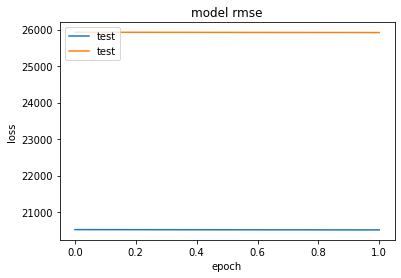

In [14]:
train = a_df["value"][((start < a_df["timestamp"]) & (a_df["timestamp"] < end))]
test =a_df["value"]
supervised_format = tsToSupervised(train, 120, 15)
train_x, train_y = getXtrainYtrain(supervised_format, 120, 15)
regressor, training_time = fitRegressor(train_x, train_y, 2, 128, "lstm_training")

In [12]:
for i in range(10):
    print(regressor.predict(train_x[i].reshape((1, 120, 1))))

[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]
[[36.710823]]


In [66]:
predictions = list()
for i in range(10, 5000):
    if i % 1000 == 0:
        print(i)
    predictions.append(regressor.predict(np.array(train[i - 10: i]).reshape((1, 10, 1)), verbose=0)[0])

1000
2000
3000
4000


In [71]:
for i in range(10):
    print(train_x[i], train_y[i])

[7045. 4270. 4407. 4401. 4370. 7252. 4228. 4266. 4217. 4121.] [6764. 4230. 4073. 4141. 4131. 6836. 4044. 4095. 4187. 4028.]
[4270. 4407. 4401. 4370. 7252. 4228. 4266. 4217. 4121. 6764.] [4230. 4073. 4141. 4131. 6836. 4044. 4095. 4187. 4028. 6717.]
[4407. 4401. 4370. 7252. 4228. 4266. 4217. 4121. 6764. 4230.] [4073. 4141. 4131. 6836. 4044. 4095. 4187. 4028. 6717. 4014.]
[4401. 4370. 7252. 4228. 4266. 4217. 4121. 6764. 4230. 4073.] [4141. 4131. 6836. 4044. 4095. 4187. 4028. 6717. 4014. 4135.]
[4370. 7252. 4228. 4266. 4217. 4121. 6764. 4230. 4073. 4141.] [4131. 6836. 4044. 4095. 4187. 4028. 6717. 4014. 4135. 4015.]
[7252. 4228. 4266. 4217. 4121. 6764. 4230. 4073. 4141. 4131.] [6836. 4044. 4095. 4187. 4028. 6717. 4014. 4135. 4015. 3948.]
[4228. 4266. 4217. 4121. 6764. 4230. 4073. 4141. 4131. 6836.] [4044. 4095. 4187. 4028. 6717. 4014. 4135. 4015. 3948. 6652.]
[4266. 4217. 4121. 6764. 4230. 4073. 4141. 4131. 6836. 4044.] [4095. 4187. 4028. 6717. 4014. 4135. 4015. 3948. 6652. 4132.]
[4217. 4

In [62]:
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
